In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
class Data(d2l.DataModule):
  def __init__(self, num_train, num_val, num_inputs, batch_size):
    self.save_hyperparameters()
    n = num_train + num_val
    self.X = torch.randn(n, num_inputs)
    noise = torch.randn(n, 1) * 0.01
    w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
    self.y = torch.matmul(self.X, w) + b + noise
  
  def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.X, self.y], train, i)
    

In [3]:
def l2_penalty(w):
  return (w ** 2).sum() / 2

In [4]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
  def __init__(self, num_inputs, lr, lambd, sigma=0.01):
    super().__init__(num_inputs, lr, sigma)
    self.save_hyperparameters()
    
  def loss(self, y_hat, y):
    return (super().loss(y_hat, y) + self.lambd * l2_penalty(self.w))

In [5]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

L2 norm of w: 0.010997610166668892


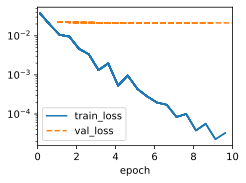

In [6]:
train_scratch(0)

L2 norm of w: 0.0015306182904168963


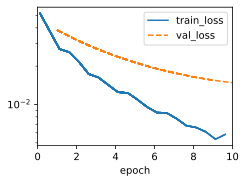

In [7]:
train_scratch(3)

In [8]:
class WeightDecay(d2l.LinearRegression):
  def __init__(self, lr, wd):
    super().__init__(lr)
    self.save_hyperparameters()
    self.wd = wd
    
  def configure_optimizers(self):
    return torch.optim.SGD(
      [
        {'params': self.net.weight, 'weight_decay': self.wd}, 
        {'params': self.net.bias}
      ],
      lr=self.lr)

L2 norm of w: 0.014839548617601395


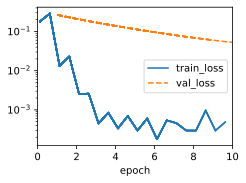

In [9]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

L2 norm of w: 0.1599290668964386


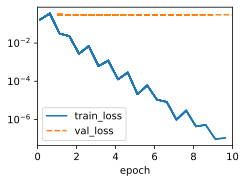

In [10]:
model = WeightDecay(wd=0, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

### Exercises

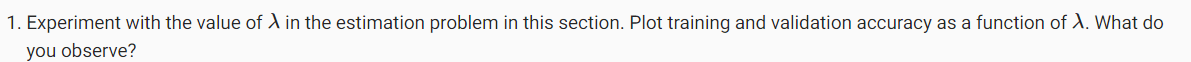

In [11]:
def rmse(y_hat: torch.Tensor, y: torch.Tensor):
  return torch.sqrt(torch.sum((y_hat - y)**2))

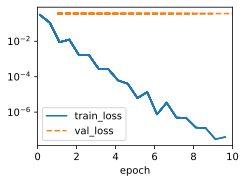

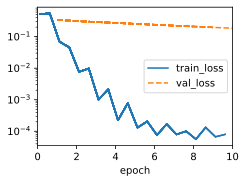

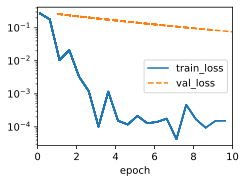

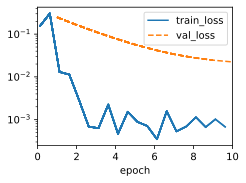

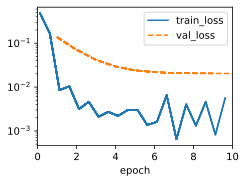

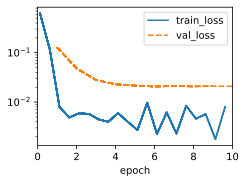

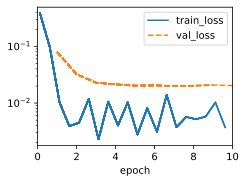

In [12]:
lambdas = torch.tensor([0, 1, 2, 5, 10, 15, 20])
train_rmse = torch.zeros_like(lambdas)
test_rmse = torch.zeros_like(lambdas)

for i, lambd in enumerate(lambdas):
  model = WeightDecay(wd=lambd, lr=0.01)
  model.board.yscale='log'
  trainer.fit(model, data)
  
  X_train, y_train = data.train_dataloader().dataset[:]
  X_test, y_test = data.val_dataloader().dataset[:]
  
  y_hat_train = model(X_train)
  y_hat_test = model(X_test)
  
  train_rmse[i] = rmse(y_hat_train, y_train)
  test_rmse[i] = rmse(y_hat_test, y_test)

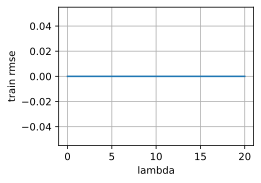

In [14]:
d2l.plot(lambdas, train_rmse, "lambda", "train rmse")

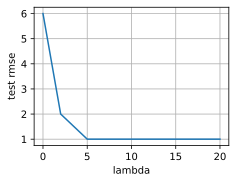

In [15]:
d2l.plot(lambdas, test_rmse, "lambda", "test rmse")

In [18]:
def l1_penalty(w: torch.Tensor):
  return w.abs().sum() / 2

In [16]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
  def __init__(self, num_inputs, lr, lambd, sigma=0.01):
    super().__init__(num_inputs, lr, sigma)
    self.save_hyperparameters()
    
  def loss(self, y_hat, y):
    return (super().loss(y_hat, y) + self.lambd * l1_penalty(self.w))

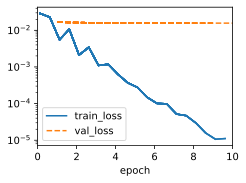

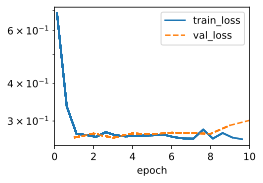

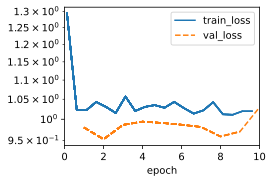

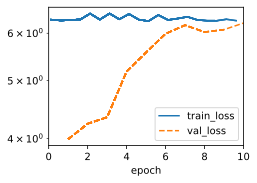

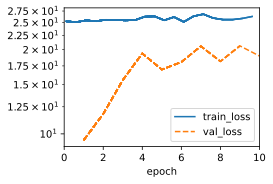

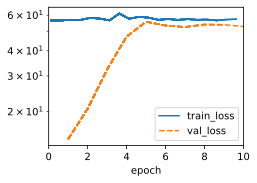

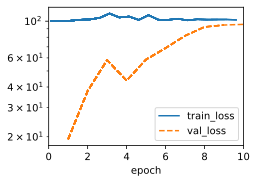

In [19]:
lambdas = torch.tensor([0, 1, 2, 5, 10, 15, 20])
train_rmse = torch.zeros_like(lambdas)
test_rmse = torch.zeros_like(lambdas)

for i, lambd in enumerate(lambdas):
  model = WeightDecayScratch(200, 0.01, lambd=lambd)
  model.board.yscale='log'
  trainer.fit(model, data)
  
  X_train, y_train = data.train_dataloader().dataset[:]
  X_test, y_test = data.val_dataloader().dataset[:]
  
  y_hat_train = model(X_train)
  y_hat_test = model(X_test)
  
  train_rmse[i] = rmse(y_hat_train, y_train)
  test_rmse[i] = rmse(y_hat_test, y_test)

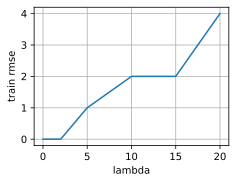

In [20]:
d2l.plot(lambdas, train_rmse, "lambda", "train rmse")

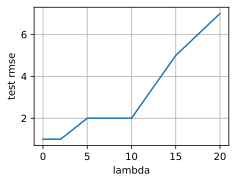

In [21]:
d2l.plot(lambdas, test_rmse, "lambda", "test rmse")

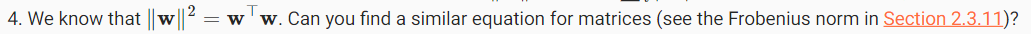

In [22]:
def frobenius_norm(W):
  return torch.sum((W.view(-1)**2))

In [23]:
W = torch.randn(3, 3)

frobenius_norm(W)

tensor(4.0882)

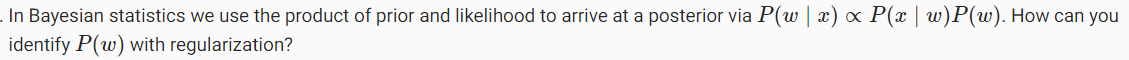

When you take the negative log of the posterior distribution, the product of the likelihood and the prior turns into a sum:$$\text{Total Loss} = \underbrace{-\log P(x|w)}_{\text{Likelihood (Data Fit)}} + \underbrace{-\log P(w)}_{\text{Prior (Regularization)}}$$By choosing a specific shape for your prior, you are choosing your regularization method:Gaussian Prior ($L_2$ Regularization): Assuming $w$ follows a normal distribution centered at zero creates the $w^2$ penalty used in Ridge regression or weight decay.Laplace Prior ($L_1$ Regularization): Assuming $w$ follows a Laplace distribution creates the $|w|$ penalty used in Lasso regression, which promotes sparsity.